In [1]:

import pandas as pd

In [2]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K


# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000]
test_data = data[20000:]

# Normalisation des données
scaler = StandardScaler()
train_data_x = scaler.fit_transform(train_data.drop(['anomaly', 'changepoint'], axis=1))
test_data_x = scaler.transform(test_data.drop(['anomaly', 'changepoint'], axis=1))
train_data_y = train_data[['anomaly']].values
test_data_y = test_data[['anomaly']].values


2024-08-19 11:20:34.107266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 11:20:34.178685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 11:20:34.179938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 11:20:35.963513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:



# Dimension de l'espace latent
input_dim = train_data_x.shape[1]
latent_dim = 4

# Encodeur
input_data = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(input_data)
h = Dense(64, activation='relu')(h)
h = Dense(32, activation='relu')(h)
h = Dense(16, activation='relu')(h)
h = Dense(8, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Echantillonnage de l'espace latent
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Décodeur
decoder_h = Dense(8, activation='relu')
decoder_h1 = Dense(16, activation='relu')
decoder_h2 = Dense(32, activation='relu')
decoder_h3 = Dense(64, activation='relu')
decoder_h4 = Dense(128, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h_decoded = decoder_h(z)
h_decoded = decoder_h1(h_decoded)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
h_decoded = decoder_h4(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

# Construction du VAE
vae = Model(input_data, x_decoded_mean)

# Définition de la perte VAE = perte de reconstruction + KL divergence
reconstruction_loss = mse(input_data, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Early stopping (optionnel)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# TensorBoard callback pour la visualisation
tensorboard_callback = TensorBoard(log_dir='./logs')

# Entraînement du modèle
epochs = 300
batch_size = 100

history = vae.fit(train_data_x, train_data_x,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(test_data_x, test_data_x),
                  callbacks=[early_stopping, tensorboard_callback])

# Définir l'encodeur
encoder = Model(input_data, z_mean)

# Définir le décodeur
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h1(_h_decoded)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h3(_h_decoded)
_h_decoded = decoder_h4(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

import os
from tensorflow.keras.models import load_model

# Définir le répertoire de sauvegarde
save_dir = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Chemins complets pour sauvegarder les modèles
vae_path = os.path.join(save_dir, 'vae_model4.h5')
encoder_path = os.path.join(save_dir, 'encoder_model4.h5')
decoder_path = os.path.join(save_dir, 'decoder_model4.h5')

# Sauvegarder les modèles
vae.save(vae_path)
encoder.save(encoder_path)
decoder.save(decoder_path)

print(f"Les modèles ont été sauvegardés dans {save_dir}")

Epoch 1/300
200/200 [==============================] - 6s 7ms/step - loss: 5.4396 - val_loss: 4.6966
Epoch 2/300
200/200 [==============================] - 1s 5ms/step - loss: 3.1191 - val_loss: 3.4907
Epoch 3/300
200/200 [==============================] - 1s 4ms/step - loss: 2.3852 - val_loss: 3.0604
Epoch 4/300
200/200 [==============================] - 1s 5ms/step - loss: 2.1476 - val_loss: 2.6994
Epoch 5/300
200/200 [==============================] - 1s 4ms/step - loss: 2.0348 - val_loss: 2.5424
Epoch 6/300
200/200 [==============================] - 1s 4ms/step - loss: 1.8710 - val_loss: 2.0787
Epoch 7/300
200/200 [==============================] - 1s 4ms/step - loss: 1.5207 - val_loss: 1.9097
Epoch 8/300
200/200 [==============================] - 1s 4ms/step - loss: 1.3667 - val_loss: 1.8146
Epoch 9/300
200/200 [==============================] - 1s 4ms/step - loss: 1.3094 - val_loss: 1.7157
Epoch 10/300
200/200 [==============================] - 1s 4ms/step - loss: 1.2586 - val_lo

/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step


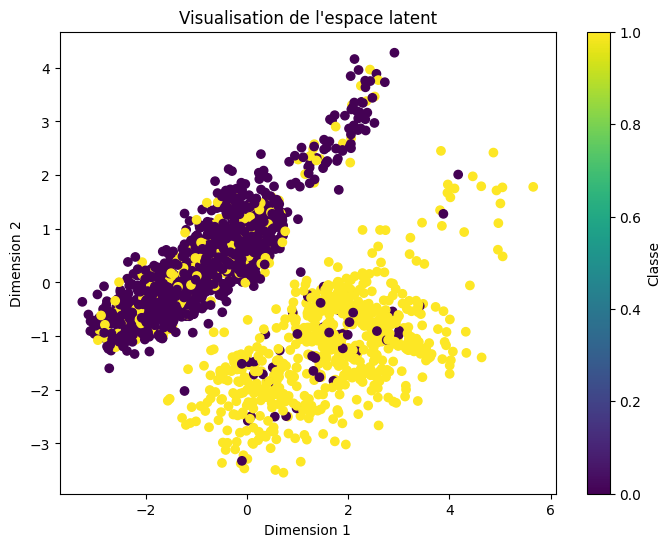

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import load_model


# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
encoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model4.h5'
encoder = load_model(encoder_path)

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Tracer les points de l'espace latent
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=test_data_y[:, 0], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent')
plt.colorbar(scatter, label='Classe')
plt.show()

78/78 [==============================] - 0s 2ms/step


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


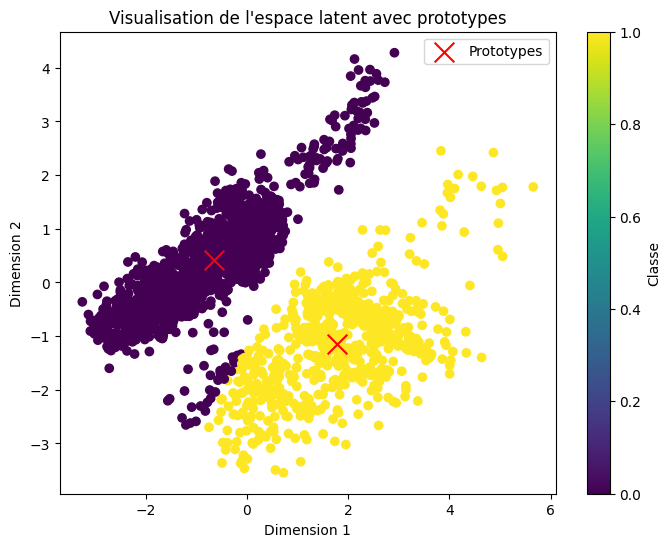

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent_2d)
prototypes = kmeans.cluster_centers_

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes[:, 0], prototypes[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [7]:
import pandas as pd
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)
test = test.iloc[:10000,:]

# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-03-01 16:46:33           0.080688           0.131922  1.745770  0.054711   
2020-03-01 16:46:35           0.080954           0.131856  1.649030  0.054711   
2020-03-01 16:46:36           0.080249           0.135997  1.683600  0.054711   
2020-03-01 16:46:37           0.081576           0.133341  0.808510  0.382638   
2020-03-01 16:46:38         

In [8]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)


[[-0.15470175 -0.17561072  0.98110401 ...  0.91511187  1.01520097
   0.37864219]
 [-0.15345788 -0.18781099  0.64289851 ...  0.91654318 -0.77365192
   0.4110445 ]
 [-0.11396124 -0.17556959  0.43200632 ...  0.91830165 -0.04263604
   0.39336197]
 ...
 [-1.33077594 -1.21367538 -1.23321769 ... -2.87377636 -0.41144428
  -2.01978718]
 [-1.32106494 -1.23187983 -2.85420713 ... -2.87676167  0.68077083
  -2.01978718]
 [-1.32695139 -1.24371683 -1.09625354 ... -2.8742671  -0.53291356
  -2.01978718]]


In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
from tensorflow.keras.losses import mse

vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5', compile=False)


reconstructions = vae.predict(X, verbose=0)
reconstruction_error = mse(reconstructions, X)
print(reconstruction_error)

tf.Tensor([0.19373185 0.1980778  0.16270198 ... 0.57316975 1.04675025 0.58860456], shape=(10000,), dtype=float64)


In [12]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df.head()

,error,y_true
0,0.193732,False
1,0.198078,False
2,0.162702,False
3,0.188970,False
4,0.372228,False


In [13]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0037	Accuracy: 0.365		Precision: 0.182	Recall Score: 0.500
Threshold: 0.0405	Accuracy: 0.416		Precision: 0.634	Recall Score: 0.536
Threshold: 0.0583	Accuracy: 0.456		Precision: 0.619	Recall Score: 0.559
Threshold: 0.0775	Accuracy: 0.486		Precision: 0.605	Recall Score: 0.572
Threshold: 0.1045	Accuracy: 0.516		Precision: 0.601	Recall Score: 0.585
Threshold: 0.1312	Accuracy: 0.540		Precision: 0.596	Recall Score: 0.592
Threshold: 0.1548	Accuracy: 0.563		Precision: 0.594	Recall Score: 0.598
Threshold: 0.1831	Accuracy: 0.579		Precision: 0.588	Recall Score: 0.595
Threshold: 0.2109	Accuracy: 0.592		Precision: 0.583	Recall Score: 0.590
Threshold: 0.2397	Accuracy: 0.605		Precision: 0.581	Recall Score: 0.584
Threshold: 0.2736	Accuracy: 0.618		Precision: 0.582	Recall Score: 0.578
Threshold: 0.3094	Accuracy: 0.623		Precision: 0.576	Recall Score: 0.565
Threshold: 0.3595	Accuracy: 0.629		Precision: 0.575	Recall Score: 0.552
Threshold: 0.4655	Accuracy: 0.629		Precision: 0.565	Recall Score

In [14]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.154806


In [15]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.193732,False,True
1,0.198078,False,True
2,0.162702,False,True
3,0.188970,False,True
4,0.372228,False,True
...,...,...,...
9995,0.583017,False,True
9996,0.590163,False,True
9997,0.573170,False,True
9998,1.046750,False,True


In [16]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.55
Taux de fausses alarmes: 0.25
Taux de manque d'alarmes: 0.56


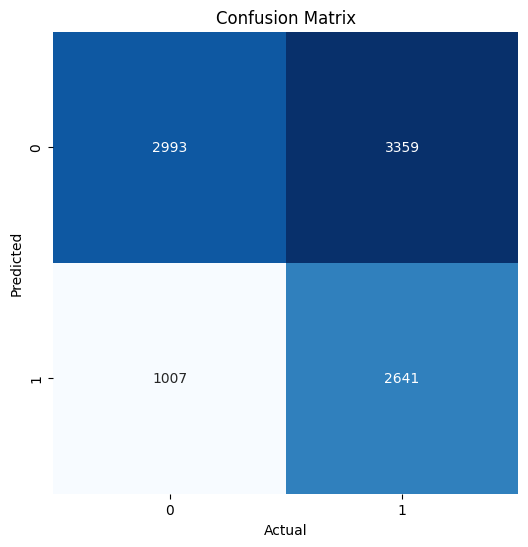

In [17]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

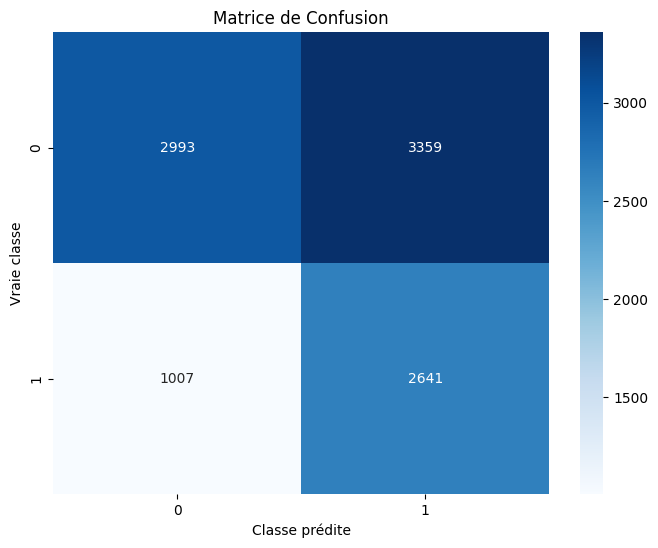

F1-score : 0.5475
Taux de faux positifs(fausses alarmes) : 0.53
Taux de faux négatifs(manque d'alarmes) : 0.28


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

313/313 [==============================] - 1s 3ms/step
Threshold: 0.1897083185067946
Nombre d'anomalies détectées: 5200


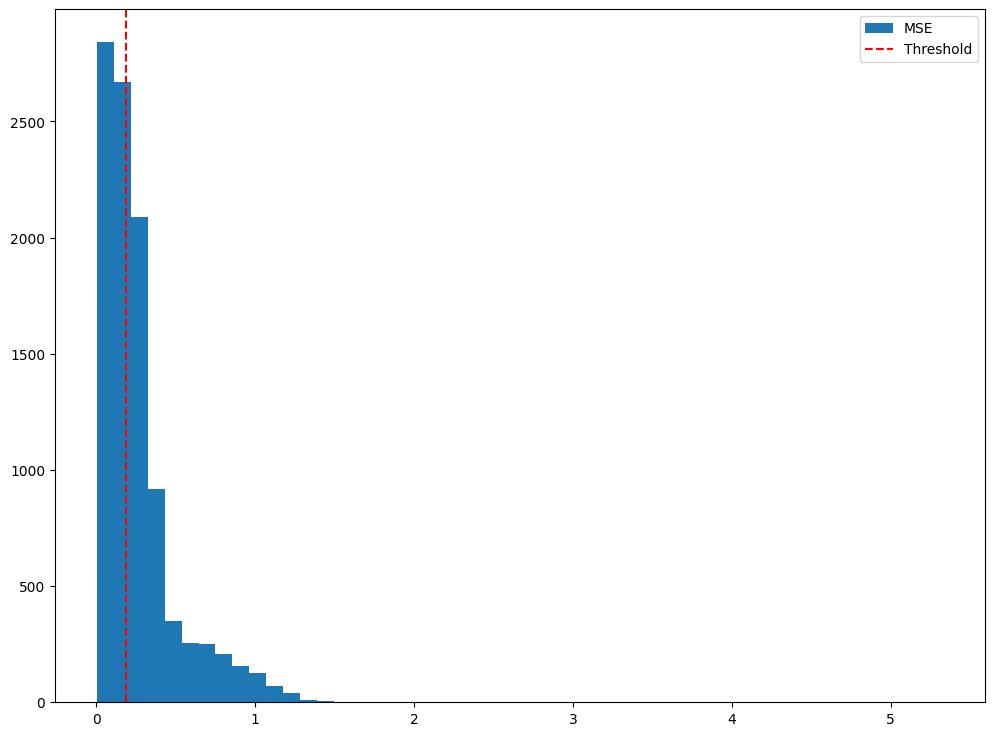

In [19]:
# Prédire les données de test et calculer l'erreur de reconstruction
X_test_pred = vae.predict(X)
mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(mse, 48)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = mse > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

# Visualiser les anomalies détectées
plt.hist(mse, bins=50, label='MSE')
plt.axvline(threshold1, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [20]:
recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.193732,False,True
1,0.198078,False,True
2,0.162702,False,False
3,0.188970,False,False
4,0.372228,False,True
...,...,...,...
9995,0.583017,False,True
9996,0.590163,False,True
9997,0.573170,False,True
9998,1.046750,False,True


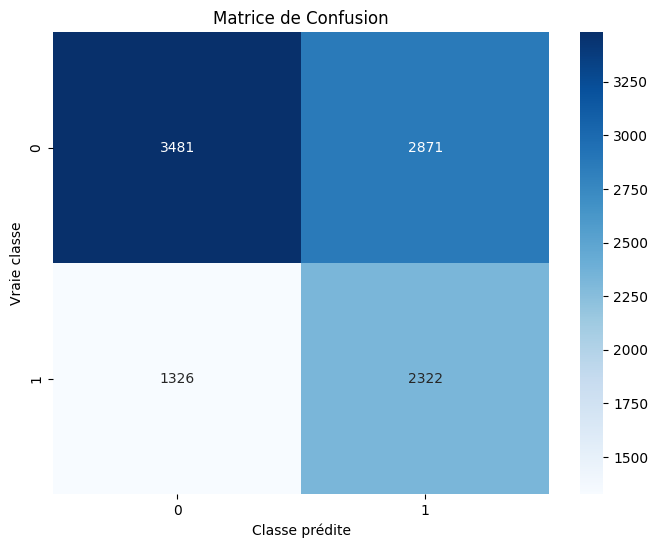

F1-score : 0.5253
Taux de faux positifs(fausses alarmes) : 0.45
Taux de faux négatifs(manque d'alarmes) : 0.36


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

# Calculer le F1-score, la précision et le rappel pour différents seuils
thresholds = np.linspace(0, max(recons_df['error']), 100)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (recons_df['error'] > threshold).astype(int)
    f1 = f1_score(recons_df['y_true'], y_pred)
    precision = precision_score(recons_df['y_true'], y_pred)
    recall = recall_score(recons_df['y_true'], y_pred)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Trouver le seuil qui maximise le F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
best_precision = precisions[best_threshold_idx]
best_recall = recalls[best_threshold_idx]

print(f"Meilleur seuil : {best_threshold:.2f}")
print(f"Meilleur F1-score : {best_f1:.2f}")
print(f"Meilleure précision : {best_precision:.2f}")
print(f"Meilleur rappel : {best_recall:.2f}")

Meilleur seuil : 0.11
Meilleur F1-score : 0.56
Meilleure précision : 0.42
Meilleur rappel : 0.83


In [23]:
recons_df1['y_pred'] = recons_df1['error'] > best_threshold
recons_df1

,error,y_true,y_pred
0,0.193732,False,True
1,0.198078,False,True
2,0.162702,False,True
3,0.188970,False,True
4,0.372228,False,True
...,...,...,...
9995,0.583017,False,True
9996,0.590163,False,True
9997,0.573170,False,True
9998,1.046750,False,True


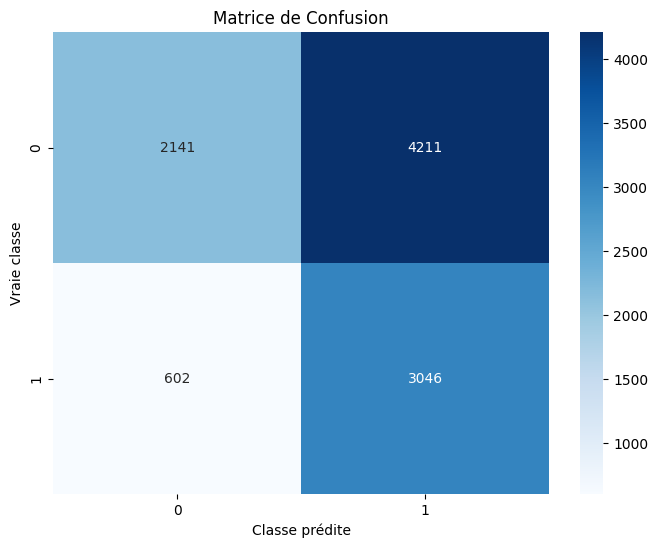

F1-score : 0.5586
Taux de faux positifs(fausses alarmes) : 0.66
Taux de faux négatifs(manque d'alarmes) : 0.17


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [25]:
testt = X[0:10000, :]
print(testt)
y_testt = y[0:10000]
print(y)
print(z[0:10000])

[[-0.15470175 -0.17561072  0.98110401 ...  0.91511187  1.01520097
   0.37864219]
 [-0.15345788 -0.18781099  0.64289851 ...  0.91654318 -0.77365192
   0.4110445 ]
 [-0.11396124 -0.17556959  0.43200632 ...  0.91830165 -0.04263604
   0.39336197]
 ...
 [-1.33077594 -1.21367538 -1.23321769 ... -2.87377636 -0.41144428
  -2.01978718]
 [-1.32106494 -1.23187983 -2.85420713 ... -2.87676167  0.68077083
  -2.01978718]
 [-1.32695139 -1.24371683 -1.09625354 ... -2.8742671  -0.53291356
  -2.01978718]]
datetime
2020-02-08 18:10:42    False
2020-02-08 18:10:43    False
2020-02-08 18:10:44    False
2020-02-08 18:10:45    False
2020-02-08 18:10:46    False
                       ...  
2020-03-01 16:46:33    False
2020-03-01 16:46:35    False
2020-03-01 16:46:36    False
2020-03-01 16:46:37    False
2020-03-01 16:46:38    False
Name: anomaly, Length: 10000, dtype: bool
datetime
2020-02-08 18:10:42    0.0
2020-02-08 18:10:43    0.0
2020-02-08 18:10:44    0.0
2020-02-08 18:10:45    0.0
2020-02-08 18:10:46  

In [26]:
import numpy as np
from sklearn.decomposition import PCA
from keras.models import load_model
from scipy.spatial.distance import euclidean

# Chargement du modèle
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5'
vae = load_model(model_path)

# Initialisation des prototypes et du buffer
prototypes = {}  # Dictionnaire pour stocker les prototypes par classe
buffer_size = 1000  # Taille maximale du buffer
buffer_X = []  # Buffer pour stocker les données d'entrée
buffer_y = []  # Buffer pour stocker les étiquettes

# Paramètres
distance_threshold = 2.0
learning_rate = 0.1  # Taux d'apprentissage initial pour la mise à jour des prototypes
forgetting_rate = 0.99  # Taux d'oubli pour le facteur de mélange

def update_model_and_prototypes(X, y, history_weight=0.7):
    """
    Met à jour le modèle et les prototypes de manière supervisée
    lorsqu'une donnée d'une classe est éloignée de son prototype.
    
    Args:
        X (numpy.ndarray): Données d'entrée
        y (numpy.ndarray): Étiquettes des données
        history_weight (float): Poids donné à l'historique lors de la mise à jour des prototypes
    """
    global learning_rate, forgetting_rate
    
    # Réduire la dimensionnalité des données à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # Prédire les classes des données
    y_pred = vae.predict(X)
    
    # Mettre à jour le modèle et les prototypes
    for i in range(len(X)):
        true_class = np.argmax(y[i])
        pred_class = np.argmax(y_pred[i])
        
        if true_class != pred_class:
            # La donnée est mal classée
            if true_class not in prototypes:
                # Initialiser le prototype s'il n'existe pas encore
                prototypes[true_class] = X_2d[i]
            else:
                prototype = prototypes[true_class]
                distance = euclidean(X_2d[i], prototype)
                
                if distance > distance_threshold:
                    # Mettre à jour le modèle
                    vae.fit(X[i:i+1], y[i:i+1], epochs=10, batch_size=1, shuffle=True)
                    
                    # Mettre à jour le prototype en utilisant APF
                    new_prototype = (1 - learning_rate) * prototype + learning_rate * X_2d[i]
                    prototypes[true_class] = history_weight * prototype + (1 - history_weight) * new_prototype
                    
                    # Mettre à jour le taux d'apprentissage en fonction de la performance sur les anciennes tâches
                    learning_rate = max(learning_rate * forgetting_rate, 0.01)
                    
                    print(f"Donnée {i} mise à jour - Vraie classe: {true_class}, Classe prédite: {pred_class}, Nouvelle distance: {distance:.2f}")
                    
                    # Ajouter la donnée au buffer
                    buffer_X.append(X[i])
                    buffer_y.append(y[i])
                    
                    # Gérer la taille du buffer
                    if len(buffer_X) > buffer_size:
                        buffer_X.pop(0)
                        buffer_y.pop(0)

# Tester le modèle sur les données de test
y_pred = vae.predict(X)

# Mettre à jour le modèle et les prototypes si nécessaire
update_model_and_prototypes(X, y)

313/313 [==============================] - 1s 2ms/step
Epoch 1/10


In [ ]:
print(y_pred)

[[-0.2427722  -0.19548008  1.1873385  ...  0.5269351   0.9723258
   0.4015969 ]
 [-0.15389869 -0.17115465  0.77424157 ...  0.4552765  -0.86330986
   0.38810623]
 [-0.12299117 -0.13915214  0.4046419  ...  0.5223282  -0.49871132
   0.3954808 ]
 ...
 [ 2.5858078   2.4731846  -0.86185795 ... -0.49411142 -0.35573763
   0.39561504]
 [ 2.6579895   2.5152202  -0.9382042  ... -0.53022254 -1.0494158
   0.43179208]
 [ 2.324814    2.5728521   1.3910338  ... -0.35557216  1.2161548
   0.20729443]]


In [ ]:
len(y_pred)

print(y_pred[1])

[-0.15389869 -0.17115465  0.77424157  0.17615746  0.20936096  0.4552765
 -0.86330986  0.38810623]


In [ ]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(y_pred, testt)
print(reconstruction_error)

tf.Tensor([0.31830616 0.32594495 0.31506663 ... 0.30680899 0.30000229 0.28146592], shape=(5000,), dtype=float64)


In [ ]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_testt
}).reset_index(drop=True)

In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold1
recons_df

,error,y_true,y_pred
0,0.318306,False,True
1,0.325945,False,True
2,0.315067,False,True
3,0.303290,False,True
4,0.414689,False,True
...,...,...,...
4995,0.248784,True,True
4996,0.284776,True,True
4997,0.306809,True,True
4998,0.300002,True,True


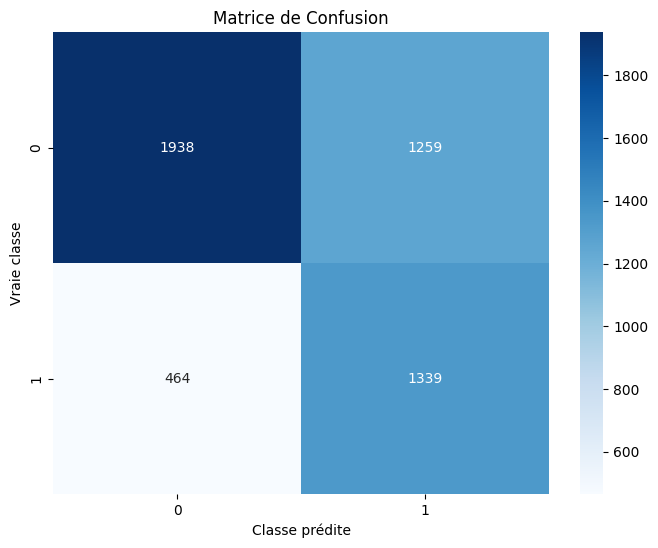

F1-score : 0.6085
Taux de faux positifs(fausses alarmes) : 0.39
Taux de faux négatifs(manque d'alarmes) : 0.26


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

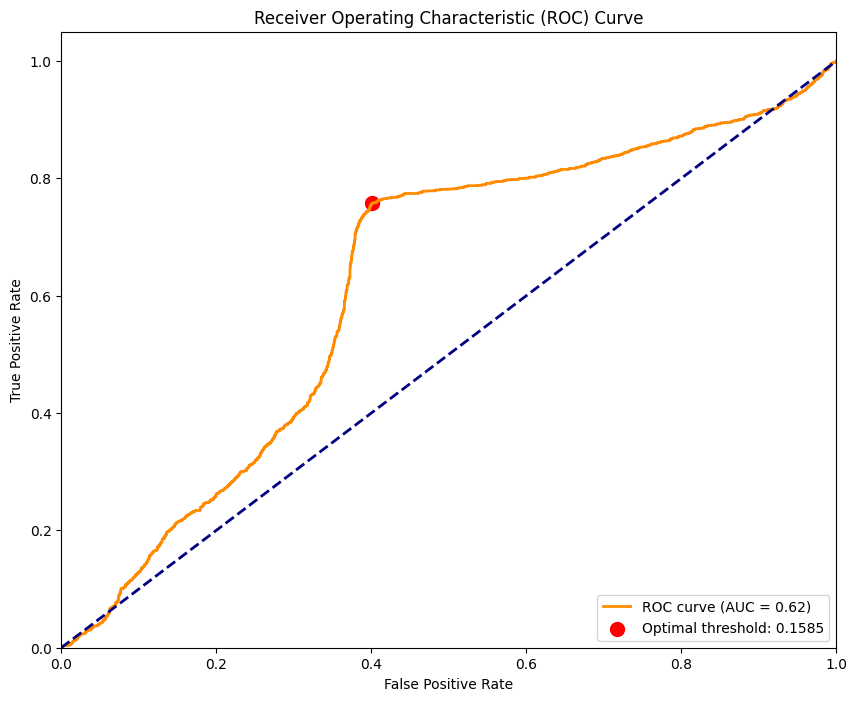

Seuil optimal: 0.1585

Matrice de confusion:
Predicted     0     1
Actual               
False      1914  1283
True        437  1366

Précision: 0.5157
Rappel: 0.7576
F1-score: 0.6137


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme vous l'avez indiqué
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(recons_df['y_true'], recons_df['error'])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Trouver le point optimal sur la courbe ROC (point le plus proche du coin supérieur gauche)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tracer la courbe ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Optimal threshold: {optimal_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Appliquer le seuil optimal pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold).astype(int)

# Afficher les résultats
print(f"Seuil optimal: {optimal_threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold)
recons_df

,error,y_true,y_pred,predicted_anomaly
0,0.318306,False,True,True
1,0.325945,False,True,True
2,0.315067,False,True,True
3,0.303290,False,True,True
4,0.414689,False,True,True
...,...,...,...,...
4995,0.248784,True,True,True
4996,0.284776,True,True,True
4997,0.306809,True,True,True
4998,0.300002,True,True,True


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

NameError: name 'recons_df' is not defined

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.61
Taux de fausses alarmes: 0.19
Taux de manque d'alarmes: 0.48


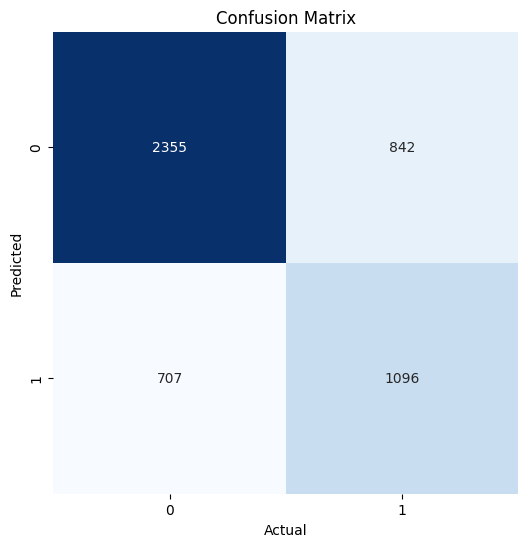

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['predicted_anomaly'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

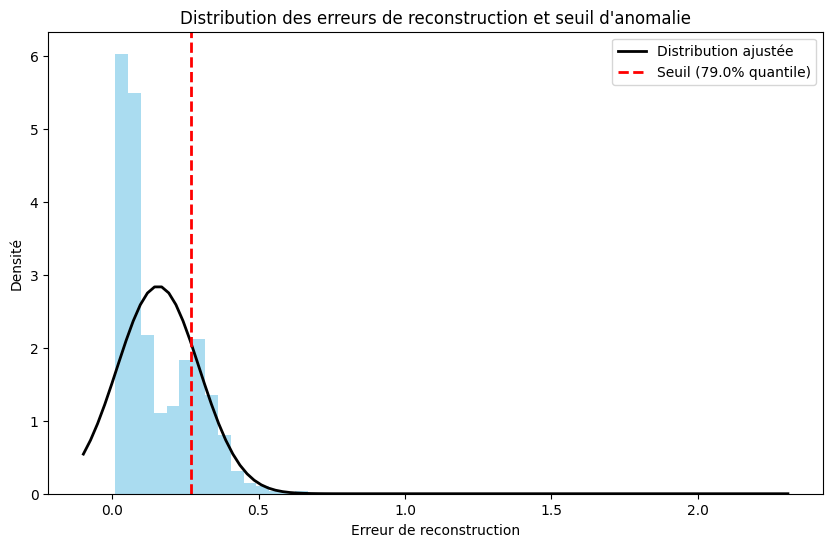

Seuil basé sur le 79.0% quantile: 0.2702

Matrice de confusion:
Predicted     0     1
Actual               
False      2470   727
True        802  1001

Précision: 0.5793
Rappel: 0.5552
F1-score: 0.5670


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Séparer les erreurs de reconstruction des instances normales
normal_errors = recons_df[recons_df['y_true'] == 0]['error']

# Ajuster une distribution gaussienne aux erreurs de reconstruction normales
mu, std = stats.norm.fit(normal_errors)

# Définir un quantile élevé (par exemple, 99%)
quantile = 0.79

# Calculer le seuil basé sur le quantile choisi
threshold = stats.norm.ppf(quantile, mu, std)

# Visualiser la distribution et le seuil
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, density=True, alpha=0.7, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title("Distribution des erreurs de reconstruction et seuil d'anomalie")
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Densité")
plt.legend(['Distribution ajustée', f'Seuil ({quantile*100}% quantile)'])
plt.show()

# Appliquer le seuil pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > threshold).astype(int)

# Afficher les résultats
print(f"Seuil basé sur le {quantile*100}% quantile: {threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,predicted_anomaly,y_pred
0,0.196005,False,0,False
1,0.207891,False,0,False
2,0.200320,False,0,False
3,0.194632,False,0,False
4,0.264240,False,0,False
...,...,...,...,...
4995,0.345993,True,1,True
4996,0.356896,True,1,True
4997,0.404213,True,1,True
4998,0.414457,True,1,True


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.57
Taux de fausses alarmes: 0.25
Taux de manque d'alarmes: 0.42


In [ ]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0111	Accuracy: 0.360		Precision: 0.180	Recall Score: 0.500
Threshold: 0.0307	Accuracy: 0.384		Precision: 0.520	Recall Score: 0.505
Threshold: 0.0416	Accuracy: 0.424		Precision: 0.556	Recall Score: 0.528
Threshold: 0.0512	Accuracy: 0.464		Precision: 0.575	Recall Score: 0.552
Threshold: 0.0635	Accuracy: 0.503		Precision: 0.586	Recall Score: 0.573
Threshold: 0.0790	Accuracy: 0.549		Precision: 0.607	Recall Score: 0.603
Threshold: 0.0983	Accuracy: 0.604		Precision: 0.637	Recall Score: 0.643
Threshold: 0.1312	Accuracy: 0.638		Precision: 0.648	Recall Score: 0.660
Threshold: 0.1890	Accuracy: 0.658		Precision: 0.650	Recall Score: 0.662
Threshold: 0.2435	Accuracy: 0.686		Precision: 0.665	Recall Score: 0.671
Threshold: 0.2751	Accuracy: 0.696		Precision: 0.668	Recall Score: 0.662
Threshold: 0.2998	Accuracy: 0.692		Precision: 0.663	Recall Score: 0.638
Threshold: 0.3231	Accuracy: 0.691		Precision: 0.667	Recall Score: 0.616
Threshold: 0.3524	Accuracy: 0.678		Precision: 0.663	Recall Score

In [ ]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.243545


In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,predicted_anomaly,y_pred
0,0.196005,False,0,False
1,0.207891,False,0,False
2,0.200320,False,0,False
3,0.194632,False,0,False
4,0.264240,False,0,True
...,...,...,...,...
4995,0.345993,True,1,True
4996,0.356896,True,1,True
4997,0.404213,True,1,True
4998,0.414457,True,1,True


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.59
Taux de fausses alarmes: 0.23
Taux de manque d'alarmes: 0.44


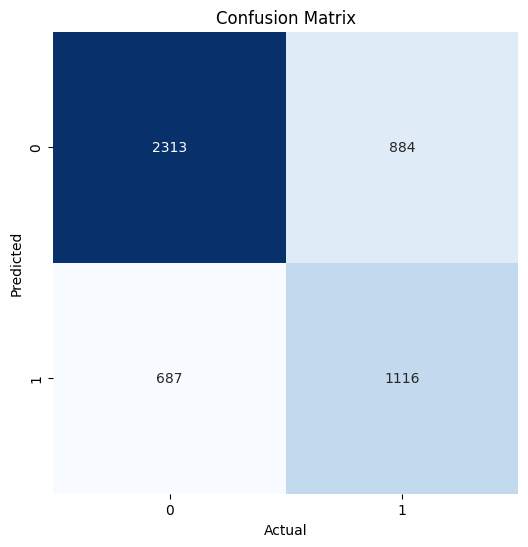

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Prédire les données de test et calculer l'erreur de reconstruction
#X_test_pred = vae.predict(X)
#mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(reconstruction_error,79)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = reconstruction_error > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")



Threshold: 0.3189366670393039
Nombre d'anomalies détectées: 1050


In [ ]:
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_testt
}).reset_index(drop=True)


recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.196005,False,False
1,0.207891,False,False
2,0.200320,False,False
3,0.194632,False,False
4,0.264240,False,False
...,...,...,...
4995,0.345993,True,True
4996,0.356896,True,True
4997,0.404213,True,True
4998,0.414457,True,True


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.46
Taux de fausses alarmes: 0.29
Taux de manque d'alarmes: 0.38


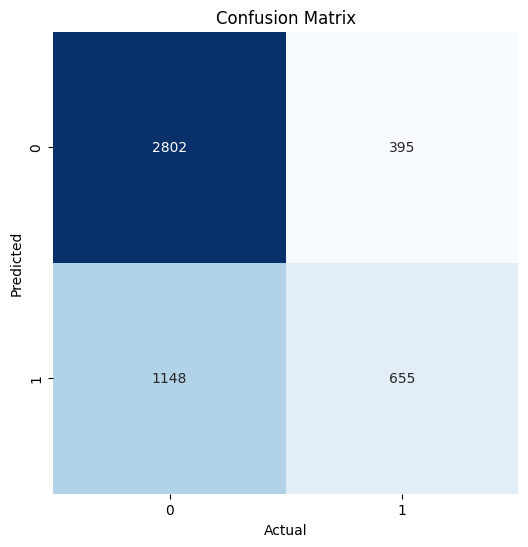

In [ ]:
cm = confusion_matrix(recons_df1['y_true'],recons_df1['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Le seuil de score d'anomalie déterminé par FDR est : 2.3159759270517144


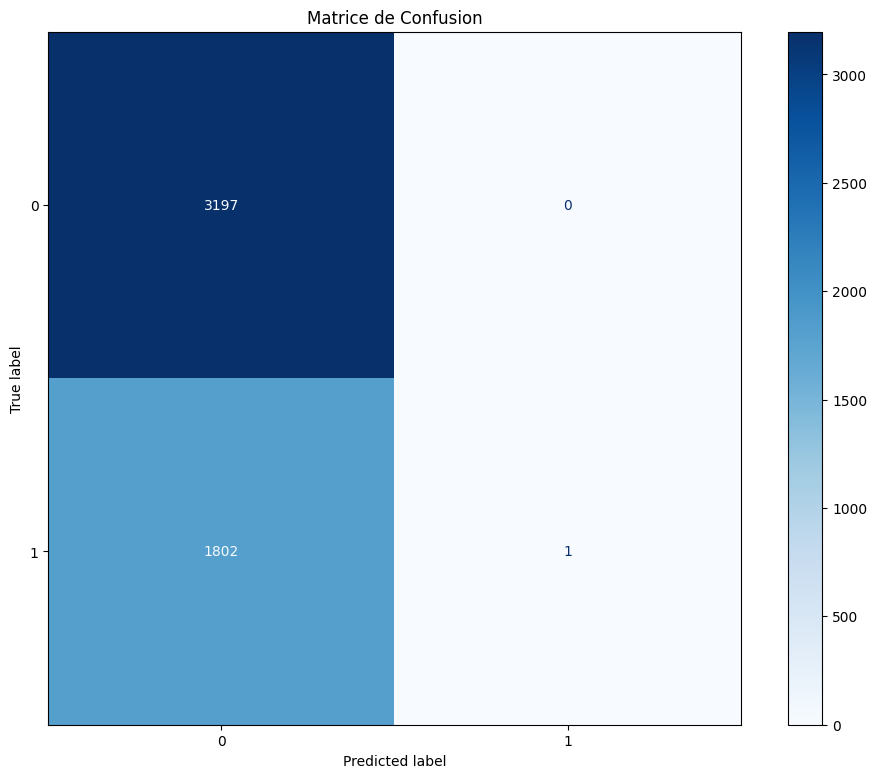

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Exemple de DataFrame recons_df avec des erreurs de reconstruction et des étiquettes vraies
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y
# }).reset_index(drop=True)

# Supposons que recons_df est déjà défini comme suit :
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y
# }).reset_index(drop=True)

# Calculer les p-valeurs
def calculate_p_values(errors, reference_errors):
    ecdf = ECDF(reference_errors)
    p_values = 1 - ecdf(errors)
    return p_values

# Appliquer la correction de Benjamini-Hochberg (BH)
def apply_bh_correction(p_values, alpha=0.05):
    m = len(p_values)
    sorted_p_values = np.sort(p_values)
    sorted_index = np.argsort(p_values)
    bh_thresholds = np.arange(1, m+1) / m * alpha
    below_threshold = sorted_p_values <= bh_thresholds
    if not np.any(below_threshold):
        return None
    max_below = np.max(np.where(below_threshold)[0])
    threshold_p_value = sorted_p_values[max_below]
    return threshold_p_value

# Séparer les erreurs de reconstruction en fonction de y_true
normal_errors = recons_df[recons_df['y_true'] == 0]['error']
anomaly_errors = recons_df[recons_df['y_true'] == 1]['error']

# Utiliser les erreurs des données normales comme référence pour les p-valeurs
p_values = calculate_p_values(recons_df['error'], normal_errors)

# Appliquer la correction BH pour déterminer le seuil
threshold_p_value = apply_bh_correction(p_values, alpha=0.15)

if threshold_p_value is not None:
    # Trouver le score d'anomalie correspondant au seuil de p-valeur
    threshold_score = np.percentile(recons_df['error'], (1 - threshold_p_value) * 100)
    print(f"Le seuil de score d'anomalie déterminé par FDR est : {threshold_score}")

    # Prédire les anomalies en utilisant le seuil
    recons_df['y_pred'] = (recons_df['error'] >= threshold_score).astype(int)

    # Calculer la matrice de confusion
    cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Tracer la matrice de confusion
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.show()
else:
    print("Aucun seuil trouvé avec le niveau de FDR spécifié.")
